In [1]:
import os
import gc
import sys
import vote
import time
import random
import pickle
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.io as pio
from maverick import Maverick
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from collections import Counter
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix

2025-02-11 20:57:30.521735: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-11 20:57:30.607714: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-11 20:57:30.609959: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-11 20:57:31.710262: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
repo_dir = "../can-fd"
if not os.path.exists(repo_dir):
    !git clone https://github.com/val-co/can-fd

DATASET_DIRECTORY = '/home/ubuntu/Maverick/can-fd/'

In [4]:
%%script echo skipping

from itertools import chain
csv_files = [file for file in os.listdir(DATASET_DIRECTORY) if file.endswith('.csv')]

X_list = []
y_list = []
y_list_extended = []

dataframes = {}

attacks = [2, 3, 4]

for i, file in enumerate(csv_files):
    file_path = os.path.join(DATASET_DIRECTORY, file)
    df = pd.read_csv(file_path)
    X_list.append(df.iloc[:, :-1])  # Append all columns except the last one (features)
    y_list.append(df.iloc[:, -1])   # Append only the last column (labels)
    y_list_extended.append(np.where(df.iloc[:, -1] == 0, 0, attacks[i]))
    
# Concatenate all DataFrames along the rows to create X (features)
X = pd.concat(X_list, ignore_index=True)

# Concatenate all Series (labels) along the rows to create y
y = pd.concat(y_list, ignore_index=True)

y_extended = list(chain(*y_list_extended))

print(X.shape, Counter(y))

with open("X_fd.pkl", 'wb') as f1:
    pickle.dump(X, f1)
    
with open("y_fd.pkl", 'wb') as f2:
    pickle.dump(y, f2)
    
with open("y_fd_extended.pkl", 'wb') as f3:
    pickle.dump(y_extended, f3)

skipping


In [ ]:
[file for file in os.listdir(DATASET_DIRECTORY) if file.endswith('.csv')]

['processed_CANFD_Flooding.csv',
 'processed_CANFD_Malfunction.csv',
 'processed_CANFD_Fuzzing.csv']

In [5]:
with open("X_fd.pkl", 'rb') as f1:
    X = pickle.load(f1)
    
with open("y_fd.pkl", 'rb') as f2:
    y = pickle.load(f2)
    
with open("y_fd_extended.pkl", 'rb') as f3:
    y_extended = pickle.load(f3)
    
print(X.shape, Counter(y), Counter(y_extended))

(7120602, 66) Counter({0: 5490129, 1: 1630473}) Counter({0: 5490129, 2: 988241, 4: 506506, 3: 135726})


In [7]:
X.head()

,dTIME,Arbitration_ID,Data[0],Data[1],Data[2],Data[3],Data[4],Data[5],Data[6],Data[7],...,Data[54],Data[55],Data[56],Data[57],Data[58],Data[59],Data[60],Data[61],Data[62],Data[63]
0,0.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.000180,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000178,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.000179,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000179,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
from sklearn.model_selection import train_test_split

# Split the data into train (60%), surrogate (20%), and test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_surrogate, X_test, y_surrogate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_surrogate shape: {X_surrogate.shape}, y_surrogate shape: {y_surrogate.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (4272361, 66), y_train shape: (4272361,)
X_surrogate shape: (1424120, 66), y_surrogate shape: (1424120,)
X_test shape: (1424121, 66), y_test shape: (1424121,)


In [9]:
y_test_extended = np.asarray(y_extended)[y_test.index]

In [7]:
X_train.columns = [col.replace('[', '(').replace(']', ')') for col in X_train.columns]
X_surrogate.columns = [col.replace('[', '(').replace(']', ')') for col in X_surrogate.columns]
X_test.columns = [col.replace('[', '(').replace(']', ')') for col in X_test.columns]

In [10]:
X_train.columns

Index(['dTIME', 'Arbitration_ID', 'Data(0)', 'Data(1)', 'Data(2)', 'Data(3)',
       'Data(4)', 'Data(5)', 'Data(6)', 'Data(7)', 'Data(8)', 'Data(9)',
       'Data(10)', 'Data(11)', 'Data(12)', 'Data(13)', 'Data(14)', 'Data(15)',
       'Data(16)', 'Data(17)', 'Data(18)', 'Data(19)', 'Data(20)', 'Data(21)',
       'Data(22)', 'Data(23)', 'Data(24)', 'Data(25)', 'Data(26)', 'Data(27)',
       'Data(28)', 'Data(29)', 'Data(30)', 'Data(31)', 'Data(32)', 'Data(33)',
       'Data(34)', 'Data(35)', 'Data(36)', 'Data(37)', 'Data(38)', 'Data(39)',
       'Data(40)', 'Data(41)', 'Data(42)', 'Data(43)', 'Data(44)', 'Data(45)',
       'Data(46)', 'Data(47)', 'Data(48)', 'Data(49)', 'Data(50)', 'Data(51)',
       'Data(52)', 'Data(53)', 'Data(54)', 'Data(55)', 'Data(56)', 'Data(57)',
       'Data(58)', 'Data(59)', 'Data(60)', 'Data(61)', 'Data(62)', 'Data(63)'],
      dtype='object')

In [8]:
from xgboost import XGBClassifier

params = {
    'max_depth': 10,  # Maximum depth of each tree
    'n_estimators': 254,  # Number of trees
    'seed': 42,  # Random seed
}

# Initialize XGBoost classifier
model1 = XGBClassifier(**params)
model1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=254, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [68]:
ypred = model1.predict(X_test)
print("Accuracy: ", accuracy_score(ypred, y_test), "\n")

tn, fp, fn, tp = confusion_matrix(ypred, y_test).ravel()
tpr = tp / (tp + fn)  # True positive rate
tnr = tn / (tn + fp)  # True negative rate
fpr = fp / (fp + tn)  # False positive rate
fnr = fn / (fn + tp)  # False negative rate
print(f"True Positive Rate (TPR): {tpr:.3f}")
print(f"True Negative Rate (TNR): {tnr:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")

Accuracy:  0.9999943824998017 

True Positive Rate (TPR): 1.000
True Negative Rate (TNR): 1.000
False Positive Rate (FPR): 0.000
False Negative Rate (FNR): 0.000


In [69]:
model2 = XGBClassifier(**params)
model2.fit(X_surrogate, y_surrogate)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=254, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [70]:
ypred = model2.predict(X_test)
print("Accuracy: ", accuracy_score(ypred, y_test), "\n")

tn, fp, fn, tp = confusion_matrix(ypred, y_test).ravel()
tpr = tp / (tp + fn)  # True positive rate
tnr = tn / (tn + fp)  # True negative rate
fpr = fp / (fp + tn)  # False positive rate
fnr = fn / (fn + tp)  # False negative rate
print(f"True Positive Rate (TPR): {tpr:.3f}")
print(f"True Negative Rate (TNR): {tnr:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")

Accuracy:  0.9999929781247521 

True Positive Rate (TPR): 1.000
True Negative Rate (TNR): 1.000
False Positive Rate (FPR): 0.000
False Negative Rate (FNR): 0.000


In [11]:
X_test_filtered = X_test[y_test == 1]
y_test_filtered = y_test[y_test == 1]
y_test_extended_filtered = y_test_extended[y_test_extended != 0]

# Print the shapes of the filtered datasets
print(f"X_test_filtered shape: {X_test_filtered.shape}")
print(f"y_test_filtered shape: {y_test_filtered.shape}")
print(f"y_test_extended_filtered shape: {y_test_extended_filtered.shape}")

X_test_filtered shape: (326229, 66)
y_test_filtered shape: (326229,)
y_test_extended_filtered shape: (326229,)


In [92]:
%%script echo skipping

A_, L_, L_extended = [], [], []

def label_checker(expected, mapping):
    return vote.mapping_check_argmax(mapping, expected)

print('Finding Adversarial Examples')
e = vote.Ensemble.from_xgboost(model2)
deltas = [0, 0] + [15] * 64 

for i in tqdm(range(len(y_test_filtered))):
    def check_robustness(m):
        o = vote.mapping_check_argmax(m, y_test_filtered.iloc[i])
        if o == vote.FAIL:
            center = [m.inputs[dim].lower + (m.inputs[dim].upper - m.inputs[dim].lower) / 2 for dim in range(m.nb_inputs)]
            if(model1.predict([center]) != y_test_filtered.iloc[i]):
                A_.append(center)
                L_.append(y_test_filtered.iloc[i])
                L_extended.append(y_test_extended_filtered[i])
        return o
    
    domain = [(max(x - delta, 0), min(65535, x + delta)) if (idx == 0 or idx == 1) else (max(x - delta, 0), min(255, x + delta)) for idx, (x, delta) in enumerate(zip(X_test_filtered.iloc[i].values, deltas))]
    e.absref(check_robustness, domain)

y_pred = model1.predict(A_)
print('Adversarial Examples Found: ', len(A_))
print("Accuracy on Adversarial Examples: ", accuracy_score(y_pred, L_))

np.save('adversarial_examples_fd.npy', A_)
np.save('true_labels_fd.npy', L_)
np.save('true_labels_fd_extended.npy', L_extended)

Finding Adversarial Examples


  0%|          | 0/326229 [00:00<?, ?it/s]

100%|██████████| 326229/326229 [21:51<00:00, 248.67it/s]


Adversarial Examples Found:  77175
Accuracy on Adversarial Examples:  0.0


In [9]:
adversarial_examples = np.load('adversarial_examples_fd.npy')
true_labels = np.load('true_labels_fd.npy')
true_labels_extended = np.load('true_labels_fd_extended.npy')

In [21]:
random.seed(42)

num_samples = len(adversarial_examples)

selected_indices = random.sample(range(len(X_test)), num_samples)

X_selected = X_test.iloc[selected_indices].values
y_selected = y_test.iloc[selected_indices].values

In [22]:
test_set = np.concatenate((X_selected, adversarial_examples))
test_lab_sym = np.concatenate((np.zeros(len(y_selected), dtype=bool), np.ones(len(true_labels), dtype=bool)))

test_lab = np.concatenate((y_selected, true_labels))

print("Evaluation Samples:", len(test_set))

Evaluation Samples: 154350


In [19]:
mav = Maverick(model1, X_train, y_train, save_filename = "autoencoder_fd_new.h5")

Initializing Maverick...


2024-12-23 18:10:51.803814: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3689610096 exceeds 10% of free system memory.
2024-12-23 18:11:46.811725: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3689610096 exceeds 10% of free system memory.
2024-12-23 18:12:46.176911: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3689610096 exceeds 10% of free system memory.
2024-12-23 18:12:48.996115: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3689610096 exceeds 10% of free system memory.


Epoch 1/50
14185/14186 [============================>.] - ETA: 0s - loss: 0.0387

2024-12-23 18:17:32.436484: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 651108680 exceeds 10% of free system memory.


14186/14186 [==============================] - 290s 15ms/step - loss: 0.0387 - val_loss: 0.0282
Epoch 2/50
14186/14186 [==============================] - 223s 16ms/step - loss: 0.0273 - val_loss: 0.0181
Epoch 3/50
14186/14186 [==============================] - 222s 16ms/step - loss: 0.0171 - val_loss: 0.0183
Epoch 4/50
14186/14186 [==============================] - 220s 15ms/step - loss: 0.0158 - val_loss: 0.0145
Epoch 5/50
14186/14186 [==============================] - 213s 15ms/step - loss: 0.0148 - val_loss: 0.0136
Epoch 6/50
14186/14186 [==============================] - 220s 15ms/step - loss: 0.0135 - val_loss: 0.0122
Epoch 7/50
14186/14186 [==============================] - 223s 16ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 8/50
14186/14186 [==============================] - 213s 15ms/step - loss: 0.0125 - val_loss: 0.0144
Epoch 9/50
14186/14186 [==============================] - 213s 15ms/step - loss: 0.0120 - val_loss: 0.0123
Epoch 10/50
14186/14186 [=======================

In [10]:
mav = Maverick(model1, load_filename="autoencoder_fd_new.h5")

Initializing Maverick...
Loading File: autoencoder_fd_new.h5
Initialization Complete!


603/603 [==============================] - 5s 6ms/step


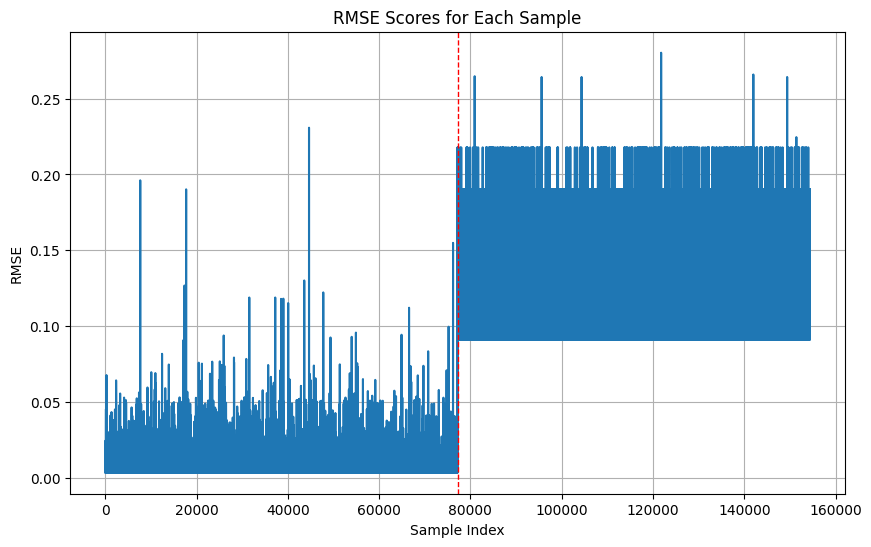

In [24]:
mav.plot_rmse_scores(pd.DataFrame(test_set, columns = X_test.columns), test_lab_sym)

In [25]:
scores = mav.anomaly_scores(pd.DataFrame(test_set, columns = X_test.columns))
fpr, tpr, thresholds = roc_curve(test_lab_sym, scores, pos_label=1)
optimal_idx = np.argmax(tpr - fpr)
threshold = thresholds[optimal_idx]
print(threshold)

603/603 [==============================] - 4s 6ms/step
0.09086040253838136


In [26]:
mav.get_metrics(pd.DataFrame(test_set, columns = X_test.columns), test_lab, threshold=0.09)

603/603 [==============================] - 4s 6ms/step
Maverick Average Prediction Time:  44.646 μs

Accuracy:  1.0
F1-Score:  1.0
MCC:  1.0
True Positive Rate (TPR): 1.000
True Negative Rate (TNR): 1.000
False Positive Rate (FPR): 0.000
False Negative Rate (FNR): 0.000


In [13]:
X_train_attack = X_train[y_train != 0]
y_train_tmp = np.asarray(y_extended)[y_train.index]
y_train_attack = y_train_tmp[y_train_tmp != 0]

# Print the shapes of the filtered datasets
print(f"X_train_attack shape: {X_train_attack.shape}")
print(f"y_train_attack shape: {y_train_attack.shape}")

X_train_attack shape: (978184, 66)
y_train_attack shape: (978184,)


## Detecting the attacker's intentions!

In [14]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

autoencoder_dir = "autoencoders"
os.makedirs(autoencoder_dir, exist_ok=True)

label_autoencoders_file = os.path.join(autoencoder_dir, 'label_autoencoders.pkl')
label_autoencoders = {}

if os.path.exists(label_autoencoders_file):
    @tf.keras.utils.register_keras_serializable(package="Custom")
    def rmse_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32) 
        y_pred = tf.cast(y_pred, tf.float32)
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
    with open(label_autoencoders_file, 'rb') as f:
        label_autoencoders = pickle.load(f)
else:
    scaler = MinMaxScaler()
    X_train_attack_ = scaler.fit_transform(X_train_attack)

    input_dim = X_train_attack.shape[1]
    encoded_dim = 5

    def build_autoencoder(input_dim, encoded_dim):
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(encoded_dim, activation='relu')(input_layer)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)
        autoencoder = Model(inputs=input_layer, outputs=decoded)
        return autoencoder

    def rmse_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32) 
        y_pred = tf.cast(y_pred, tf.float32)
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

    unique_labels = np.unique(y_train_attack)
    label_autoencoders = {}
    histories = {}

    for label in unique_labels:
        print(f"Training autoencoder for label {label}")
        label_data = X_train_attack_[y_train_attack == label]
        autoencoder = build_autoencoder(input_dim, encoded_dim)
        autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=rmse_loss)

        # Set up EarlyStopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, min_delta=1e-5)

        history = autoencoder.fit(
            label_data, label_data, 
            epochs=250,
            batch_size=256,
            shuffle=True,
            validation_split=0.1,
            callbacks=[early_stopping]
        )

        label_autoencoders[label] = autoencoder
        histories[label] = history

    with open(os.path.join(autoencoder_dir, 'label_autoencoders.pkl'), 'wb') as f:
        pickle.dump(label_autoencoders, f)

In [21]:
unique_labels = np.unique(y_train_attack)

scaler_adv = MinMaxScaler()
adversarial_examples_ = scaler_adv.fit_transform(adversarial_examples) 

all_losses = []
for label in unique_labels:
    autoencoder = label_autoencoders[label]
    reconstructed = autoencoder.predict(adversarial_examples_, batch_size=256)
    losses = np.sqrt(np.mean((adversarial_examples_ - reconstructed) ** 2, axis=1))
    all_losses.append(losses)

all_losses = np.array(all_losses).T  # Shape: (num_examples, num_labels)
predicted_labels = unique_labels[np.argmin(all_losses, axis=1)]  # Label with lowest loss per example

302/302 [==============================] - 1s 3ms/step


In [22]:
from sklearn.metrics import f1_score, precision_score, recall_score, balanced_accuracy_score

precision = precision_score(true_labels_extended, predicted_labels, average='macro') 
recall = recall_score(true_labels_extended, predicted_labels, average='macro') 
f1 = f1_score(true_labels_extended, predicted_labels, average='macro') 
balanced_acc = balanced_accuracy_score(true_labels_extended, predicted_labels)

print(f"Balanced Accuracy: {balanced_acc:.3f}")
print(f"Precision (macro-average): {precision:.3f}")
print(f"Recall (macro-average): {recall:.3f}")
print(f"F1 Score (macro-average): {f1:.3f}")


Balanced Accuracy: 1.000
Precision (macro-average): 1.000
Recall (macro-average): 1.000
F1 Score (macro-average): 1.000


# Tuning the ratio of Adversarial:Non-Adversarial Samples for Evaluation

In [11]:
import math
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score, matthews_corrcoef, roc_auc_score
import plotly.graph_objects as go

from plotly.subplots import make_subplots

random.seed(42)
np.random.seed(42)

dataset_name = 'HCRL-CAN-FD'

num_samples = len(adversarial_examples)
selected_indices = random.sample(range(len(X_test)), num_samples)

X_test_ = X_test.iloc[selected_indices].values
y_test_ = y_test.iloc[selected_indices].values

# Ratios to analyze
ratios = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Metrics storage
mcc_list, f1score_list, precision_list, recall_list, fpr_list, fnr_list, accuracy_list, auc_list = [], [], [], [], [], [], [], []
ratio_labels = []

for adv_count in ratios:

    # Sampling with fixed seed
    np.random.seed(42)

    # Sample the indices for original and adversarial examples based on the desired ratio
    adv_indices = np.random.choice(len(adversarial_examples), math.ceil((adv_count/100)*len(adversarial_examples)))

    np.random.seed(42)
    remove_indices = np.random.choice(len(X_test_), len(adv_indices), replace=False)
    X_test__ = np.delete(X_test_, remove_indices, axis=0)
    y_test__ = np.delete(y_test_, remove_indices, axis=0)
    
    # Combine the data
    combined_data = np.vstack((X_test__, adversarial_examples[adv_indices]))
    combined_labels = np.hstack((y_test__, true_labels[adv_indices]))

    print("Ratio (Adv : Non-Adv) -", len(adversarial_examples[adv_indices]), len(X_test__))

    # Calculate and print ratio
    r = adv_count
    ratio_labels.append(f"{r}:{100-r}")  # Corrected formatting

    # Predictions
    predictions = mav.predict(pd.DataFrame(combined_data, columns=X_test.columns), threshold=0.09)

    # Metrics
    mcc = matthews_corrcoef(combined_labels, predictions)
    accuracy = accuracy_score(combined_labels, predictions)
    f1score = f1_score(combined_labels, predictions)
    precision = precision_score(combined_labels, predictions)
    recall = recall_score(combined_labels, predictions)
    accuracy = accuracy_score(combined_labels, predictions)
    auc = roc_auc_score(combined_labels, predictions)

    TN, FP, FN, TP = confusion_matrix(combined_labels, predictions).ravel()
    fpr = FP / (FP + TN) 
    fnr = FN / (FN + TP)

    # Store metrics
    f1score_list.append(f1score)
    precision_list.append(precision)
    recall_list.append(recall)
    fpr_list.append(fpr)
    fnr_list.append(fnr)
    mcc_list.append(mcc)
    accuracy_list.append(accuracy)
    auc_list.append(auc)

Ratio (Adv : Non-Adv) - 0 77175
302/302 [==============================] - 2s 6ms/step
Ratio (Adv : Non-Adv) - 772 76403
302/302 [==============================] - 2s 5ms/step
Ratio (Adv : Non-Adv) - 1544 75631
302/302 [==============================] - 2s 5ms/step
Ratio (Adv : Non-Adv) - 2316 74859
302/302 [==============================] - 2s 6ms/step
Ratio (Adv : Non-Adv) - 3087 74088
302/302 [==============================] - 2s 5ms/step
Ratio (Adv : Non-Adv) - 3859 73316
302/302 [==============================] - 2s 6ms/step
Ratio (Adv : Non-Adv) - 4631 72544
302/302 [==============================] - 2s 5ms/step
Ratio (Adv : Non-Adv) - 5403 71772
302/302 [==============================] - 2s 6ms/step
Ratio (Adv : Non-Adv) - 6174 71001
302/302 [==============================] - 2s 6ms/step
Ratio (Adv : Non-Adv) - 6946 70229
302/302 [==============================] - 2s 6ms/step
Ratio (Adv : Non-Adv) - 7718 69457
302/302 [==============================] - 2s 6ms/step


In [21]:
# Creating subplots
fig = make_subplots(
    rows=2, cols=4, 
    subplot_titles=("F1-Score", "Precision", "Recall", "Accuracy", "FPR", "FNR", "MCC", "AUC"),
    horizontal_spacing=0.03, vertical_spacing=0.12
)

# Adding traces
fig.add_trace(go.Scatter(x=ratio_labels, y=f1score_list, mode='lines+markers', name='F1-Score'), row=1, col=1)
fig.add_trace(go.Scatter(x=ratio_labels, y=precision_list, mode='lines+markers', name='Precision'), row=1, col=2)
fig.add_trace(go.Scatter(x=ratio_labels, y=recall_list, mode='lines+markers', name='Recall'), row=1, col=3)
fig.add_trace(go.Scatter(x=ratio_labels, y=accuracy_list, mode='lines+markers', name='Accuracy'), row=1, col=4)
fig.add_trace(go.Scatter(x=ratio_labels, y=fpr_list, mode='lines+markers', name='FPR'), row=2, col=1)
fig.add_trace(go.Scatter(x=ratio_labels, y=fnr_list, mode='lines+markers', name='FNR'), row=2, col=2)
fig.add_trace(go.Scatter(x=ratio_labels, y=mcc_list, mode='lines+markers', name='MCC'), row=2, col=3)
fig.add_trace(go.Scatter(x=ratio_labels, y=auc_list, mode='lines+markers', name='AUC'), row=2, col=4)

# Update layout
fig.update_layout(
    title={'text': f'Varying the ratio of Adversarial to Non-Adversarial Samples during Evaluation for {dataset_name} (X-axis: Adversarial:Non-Adversarial Ratio, Y-axis: Metric Value)', 'x': 0.5, 'xanchor': 'center'},
    height=300, width=950,
    showlegend=False,
    margin=dict(l=10, r=10, t=40, b=10),
    font=dict(size=8),  # General font size for axis text and other elements
)

# Update subplot titles font size
fig.update_layout(
    annotations=[dict(
        font=dict(size=9),  # Reduced font size for subplot titles
        xref="paper", yref="paper",
        showarrow=False
    ) for _ in range(8)]
)

eps = 0.05

fig.update_yaxes(range=[0, 1+eps], row=1, col=1, zeroline=True, dtick=0.25)
fig.update_yaxes(range=[0, 1+eps], row=1, col=2, zeroline=True, dtick=0.25)
fig.update_yaxes(range=[0, 1+eps], row=1, col=3, zeroline=True, dtick=0.25)
fig.update_yaxes(range=[0, 1+eps], row=1, col=4, zeroline=True, dtick=0.25)
fig.update_yaxes(range=[0-eps, 1], row=2, col=1, zeroline=False, dtick=0.25)
fig.update_yaxes(range=[0-eps, 1], row=2, col=2, zeroline=False, dtick=0.25)
fig.update_yaxes(range=[-1, 1+0.1], row=2, col=3, zeroline=False, dtick=0.50)
fig.update_yaxes(range=[0, 1+eps], row=2, col=4, zeroline=True, dtick=0.25)

# Increase the spacing between the graph and the ratio labels
fig.update_xaxes(linewidth=0.5, linecolor='pink', mirror=True, tickfont=dict(size=5), ticklabelposition="outside", ticklabelstandoff=2, dtick=0.1)
fig.update_yaxes(linewidth=0.5, linecolor='pink', mirror=True, tickfont=dict(size=5), ticklabelposition="outside", ticklabelstandoff=2)

fig.show()

In [22]:
fig.write_image("hcrl-vary.png", width=900, height=300, scale=5) 

In [30]:
from prettytable import PrettyTable

# Initialize table
table = PrettyTable()
table.field_names = ["Ratio", "F1-Score", "Precision", "Recall", "Accuracy", "FPR", "FNR", "MCC", "AUC"]

# Add rows with formatted values
for i in range(len(ratio_labels)):
    table.add_row([
        ratio_labels[i], 
        f"{f1score_list[i]:.3f}", f"{precision_list[i]:.3f}", f"{recall_list[i]:.3f}", 
        f"{accuracy_list[i]:.3f}", f"{fpr_list[i]:.3f}", f"{fnr_list[i]:.3f}", 
        f"{mcc_list[i]:.3f}", f"{auc_list[i]:.3f}"
    ])

# Print table
print(table)


+-------+----------+-----------+--------+----------+-------+-------+-------+-------+
| Ratio | F1-Score | Precision | Recall | Accuracy |  FPR  |  FNR  |  MCC  |  AUC  |
+-------+----------+-----------+--------+----------+-------+-------+-------+-------+
| 0:100 |  0.999   |   1.000   | 0.999  |  1.000   | 0.000 | 0.001 | 0.999 | 0.999 |
|  1:99 |  0.999   |   1.000   | 0.999  |  1.000   | 0.000 | 0.001 | 0.999 | 0.999 |
|  2:98 |  0.999   |   1.000   | 0.999  |  1.000   | 0.000 | 0.001 | 0.999 | 0.999 |
|  3:97 |  0.999   |   1.000   | 0.999  |  1.000   | 0.000 | 0.001 | 0.999 | 1.000 |
|  4:96 |  0.999   |   1.000   | 0.999  |  1.000   | 0.000 | 0.001 | 0.999 | 1.000 |
|  5:95 |  1.000   |   1.000   | 0.999  |  1.000   | 0.000 | 0.001 | 0.999 | 1.000 |
|  6:94 |  1.000   |   1.000   | 0.999  |  1.000   | 0.000 | 0.001 | 0.999 | 1.000 |
|  7:93 |  1.000   |   1.000   | 0.999  |  1.000   | 0.000 | 0.001 | 0.999 | 1.000 |
|  8:92 |  1.000   |   1.000   | 0.999  |  1.000   | 0.000 | 0.00